# Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import requests
import io
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Load Dataset

In [2]:
def get_dataset(url = "https://raw.githubusercontent.com/JULIELab/EmoBank/master/corpus/emobank.csv"):
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(io.StringIO(response.text))
    else:
        raise Exception(f"Failed to download the dataset. Status code: {response.status_code}")

In [3]:
data = get_dataset()

In [4]:
data.head()

,id,split,V,A,D,text
0,110CYL068_1036_1079,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,110CYL068_1079_1110,test,2.80,3.10,2.80,If I wasn't working here.
2,110CYL068_1127_1130,train,3.00,3.00,3.00,".."""
3,110CYL068_1137_1188,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,110CYL068_1189_1328,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...


# Step 3: Exploratory Data Analysis

Visualize the distribution of Valence, Arousal, and Dominance

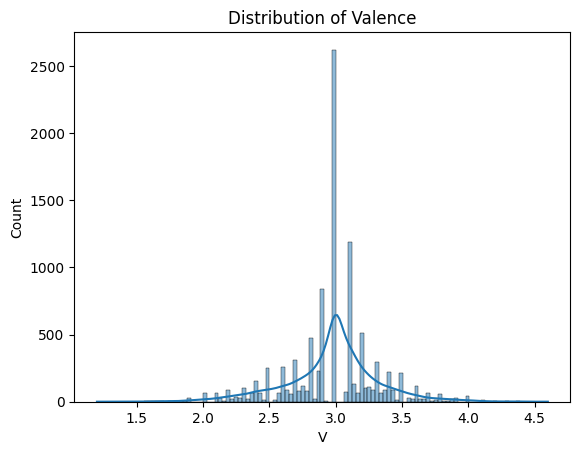

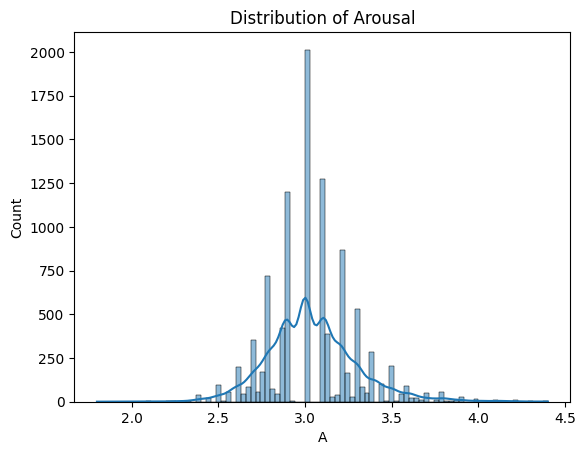

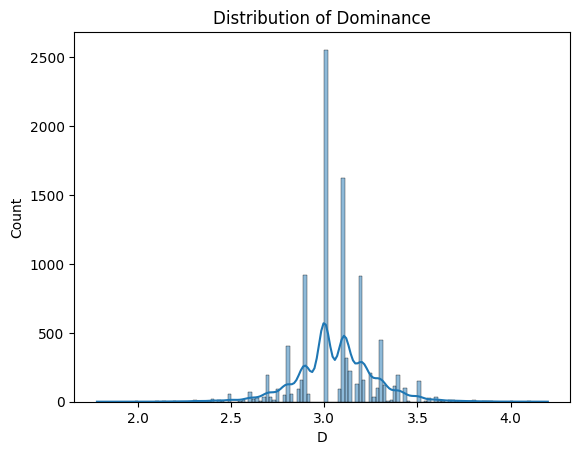

In [5]:
sns.histplot(data['V'], kde=True).set_title('Distribution of Valence')
plt.show()

sns.histplot(data['A'], kde=True).set_title('Distribution of Arousal')
plt.show()

sns.histplot(data['D'], kde=True).set_title('Distribution of Dominance')
plt.show()

# Step 4: Preprocessing

Split into training and testing sets

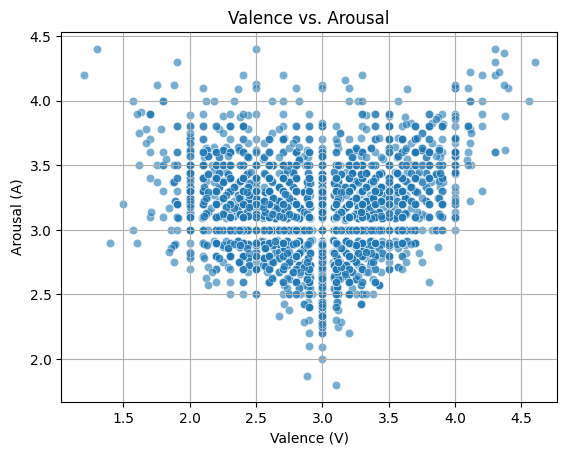

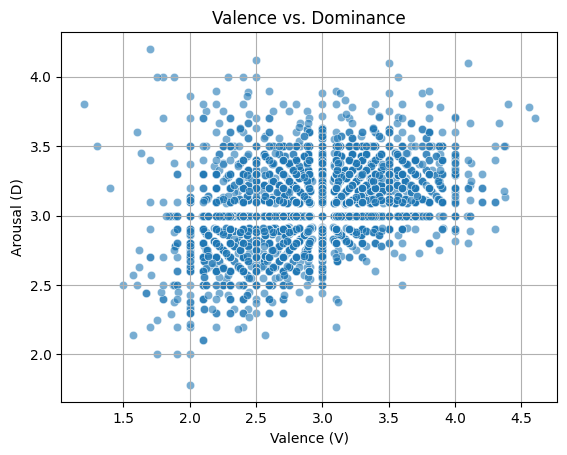

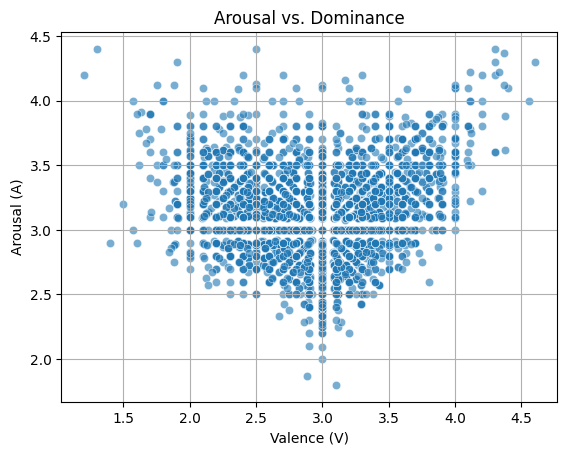

In [6]:
# Drop rows with NaN in V or A
data = data.dropna(subset=['V', 'A', 'D'])

# Define a function to remove outliers using IQR
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to Valence (V), Arousal (A), and Dominance (D)
# data = remove_outliers(data, 'V')
# data = remove_outliers(data, 'A')
# data = remove_outliers(data, 'D')

# Replace NaN with a placeholder (e.g., an empty string)
data['text'] = data['text'].fillna('')

# Scatter plot for Valence (V) and Arousal (A)
sns.scatterplot(x='V', y='A', data=data, alpha=0.6)

# Customize the plot
plt.xlabel("Valence (V)")
plt.ylabel("Arousal (A)")
plt.title("Valence vs. Arousal")

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

# Scatter plot for Valence (V) and Dominance (D)
sns.scatterplot(x='V', y='D', data=data, alpha=0.6)

# Customize the plot
plt.xlabel("Valence (V)")
plt.ylabel("Arousal (D)")
plt.title("Valence vs. Dominance")

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

# Scatter plot for Arousal (A) and Dominance (D)
sns.scatterplot(x='V', y='A', data=data, alpha=0.6)

# Customize the plot
plt.xlabel("Valence (V)")
plt.ylabel("Arousal (A)")
plt.title("Arousal vs. Dominance")

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

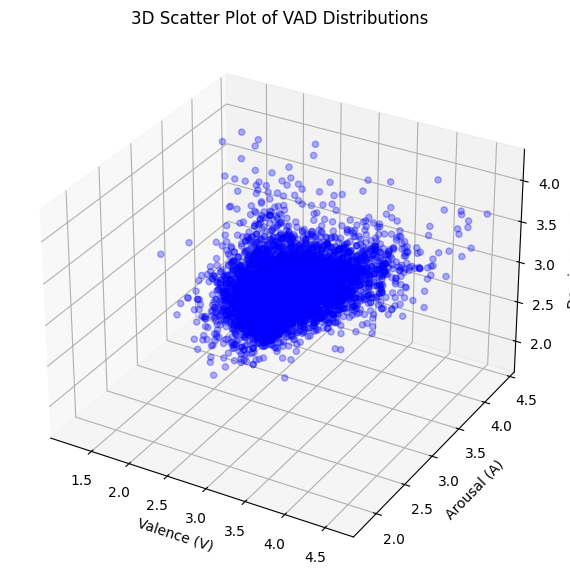

In [7]:
# Create a figure for 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['V'], data['A'], data['D'], color='blue', label='Actual VAD', alpha=0.3)

ax.set_xlabel('Valence (V)')
ax.set_ylabel('Arousal (A)')
ax.set_zlabel('Dominance (D)')
ax.set_title('3D Scatter Plot of VAD Distributions')

# Show the plot
plt.show()

In [8]:
# Continue with train-test split and TF-IDF processing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# --- Preprocessing options: CountVectorizer, TF-IDF, Word2Vec ---

# Option 1: Using CountVectorizer for LDA (original approach)

# count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
# data_counts = count_vectorizer.fit_transform(data['text'])
# X_train_counts = count_vectorizer.transform(train_data['text'])
# X_test_counts = count_vectorizer.transform(test_data['text'])
# # Applying LDA
# lda = LatentDirichletAllocation(n_components=20, random_state=42)
# lda.fit_transform(data_counts)
# X_train = lda.transform(X_train_counts)
# X_test = lda.transform(X_test_counts)

# Option 2: Using TF-IDF (new approach)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
data_tfidf = tfidf_vectorizer.fit_transform(data['text'])
X_train = tfidf_vectorizer.transform(train_data['text'])
X_test = tfidf_vectorizer.transform(test_data['text'])

# Option 3: Using Word2Vec (new approach)

# from gensim.models import Word2Vec
# def preprocess_word2vec(corpus):
#     return [sentence.split() for sentence in corpus]

# # Train Word2Vec on the training corpus
# word2vec_model = Word2Vec(sentences=preprocess_word2vec(train_data['text']), vector_size=100, window=5, min_count=2, workers=4)

# def get_word2vec_embedding(text):
#     words = text.split()
#     vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
#     if len(vectors) > 0:
#         return np.mean(vectors, axis=0)
#     else:
#         return np.zeros(word2vec_model.vector_size)

# # Transform the training and testing datasets into Word2Vec embeddings
# X_train = np.array([get_word2vec_embedding(text) for text in train_data['text']])
# X_test = np.array([get_word2vec_embedding(text) for text in test_data['text']])

# Choose targets for Valence, Arousal, and Dominance
v_train, v_test = train_data['V'], test_data['V']
a_train, a_test = train_data['A'], test_data['A']
d_train, d_test = train_data['D'], test_data['D']

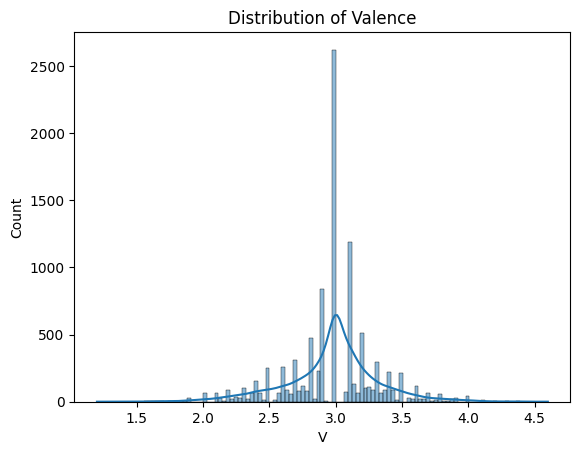

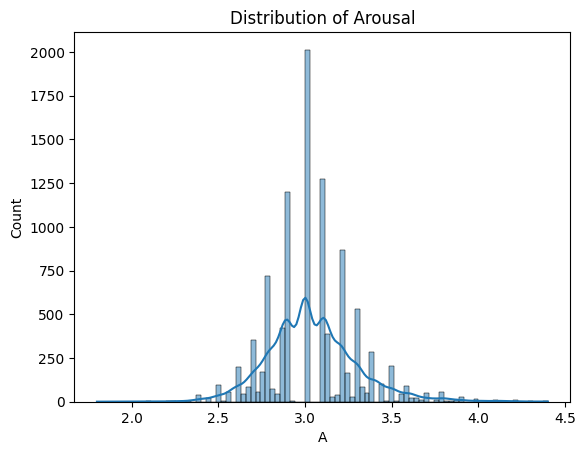

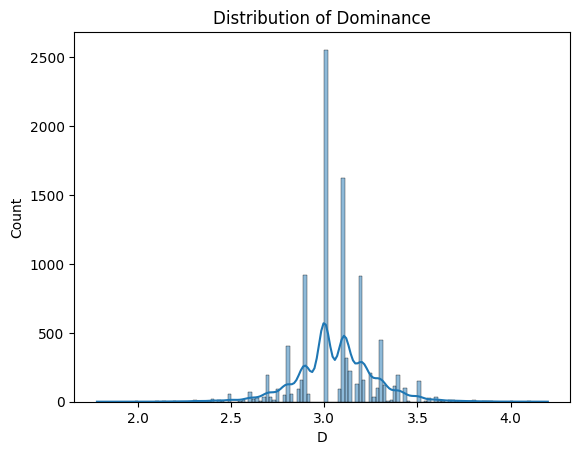

In [9]:
sns.histplot(data['V'], kde=True).set_title('Distribution of Valence')
plt.show()

sns.histplot(data['A'], kde=True).set_title('Distribution of Arousal')
plt.show()

sns.histplot(data['D'], kde=True).set_title('Distribution of Dominance')
plt.show()

# Step 5: Build Models

# 5.1 Ridge

In [10]:
model_v = Ridge(alpha=1.0)
model_v.fit(X_train, v_train)

model_a = Ridge(alpha=1.0)
model_a.fit(X_train, a_train)

model_d = Ridge(alpha=1.0)
model_d.fit(X_train, d_train)

ridge_model = (model_v, model_a, model_d)

## 5.2 Random Forest

In [98]:
model_v = RandomForestRegressor(n_estimators=100, random_state=42)
model_v.fit(X_train, v_train)

model_a = RandomForestRegressor(n_estimators=100, random_state=42)
model_a.fit(X_train, a_train)

model_d = RandomForestRegressor(n_estimators=100, random_state=42)
model_d.fit(X_train, d_train)

rf_model = (model_v, model_a, model_d)

## 5.3 Neural Network Regression

In [99]:
model_v = MLPRegressor(hidden_layer_sizes=(50, 30), activation='relu', solver='adam', random_state=42, max_iter=500)
model_v.fit(X_train, v_train)

model_a = MLPRegressor(hidden_layer_sizes=(50, 30), activation='relu', solver='adam', random_state=42, max_iter=500)
model_a.fit(X_train, a_train)

model_d = MLPRegressor(hidden_layer_sizes=(50, 30), activation='relu', solver='adam', random_state=42, max_iter=500)
model_d.fit(X_train, d_train)

mlp_model = (model_v, model_a, model_d)

In [100]:
models = [ridge_model, rf_model, mlp_model]
# models = [ridge_model]

# Step 6: Evaluate the Models

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

for model in models:
    print(f"For model:", model)
    (model_v, model_a, model_d) = model

    v_pred = model_v.predict(X_test)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(v_test, v_pred)
    print("Mean Squared Error:", mse)

    # Visualize predictions vs. true values
    plt.scatter(v_test, v_pred, alpha=0.6)
    plt.xlabel("True Valence Values")
    plt.ylabel("Valence Predictions")
    plt.title("True Valence Values vs. Predictions")
    plt.show()
    
    a_pred = model_a.predict(X_test)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(a_test, a_pred)
    print("Mean Squared Error:", mse)

    # Visualize predictions vs. true values
    plt.scatter(a_test, a_pred, alpha=0.6)
    plt.xlabel("True Arousal Values")
    plt.ylabel("Arousal Predictions")
    plt.title("True Arousal Values vs. Predictions")
    plt.show()

    d_pred = model_d.predict(X_test)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(d_test, d_pred)
    print("Mean Squared Error:", mse)

    # Visualize predictions vs. true values
    plt.scatter(d_test, d_pred, alpha=0.6)
    plt.xlabel("True Dominance Values")
    plt.ylabel("Dominance Predictions")
    plt.title("True Dominance Values vs. Predictions")
    plt.show()

    # Create a figure for 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter true VAD values (from the test set)
    ax.scatter(v_test, a_test, d_test, color='blue', label='Actual VAD', alpha=0.125)

    # Scatter predicted VAD values
    ax.scatter(v_pred, a_pred, d_pred, color='red', label='Predicted VAD', alpha=0.325)

    # Set labels
    ax.set_xlabel('Valence (V)')
    ax.set_ylabel('Arousal (A)')
    ax.set_zlabel('Dominance (D)')
    ax.set_title('3D Scatter Plot of Predicted vs. Actual VAD')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
# To Do: Plot R-Squared, MSE, and MAE

# Step7: Making Predictions

In [102]:
def predict(message, model):
    (model_v, model_a, model_d) = model
    v = model_v.predict(message)
    a = model_a.predict(message)
    d = model_d.predict(message)
    return v, a, d

In [ ]:
# Get a few sample texts from the test data for prediction
sampled_data = test_data.sample(10)
messages = sampled_data['text'].values

# --- Handling specific instances ---

# If using LDA:
# input_message = lda.transform(count_vectorizer.transform(messages))

# If using TF-IDF:
input_message = tfidf_vectorizer.transform(messages)

# If using Word2Vec:
# input_message = np.array([get_word2vec_embedding(text) for text in messages])


for model in models:
    print(f"For model:", model)
    (model_v, model_a, model_d) = model

    # Get predictions for the new messages
    v_pred, a_pred, d_pred = predict(input_message, model)

    # Display results for each message
    for i, msg in enumerate(messages):
        print(f"Message: {msg}")
        print(f"Predicted Valence: {v_pred[i]:.2f}, Arousal: {a_pred[i]:.2f}, Dominance: {d_pred[i]:.2f}")
        print(f"Actual Valence: {sampled_data['V'].values[i]:.2f}, Arousal: {sampled_data['A'].values[i]:.2f}, Dominance: {sampled_data['D'].values[i]:.2f}\n")

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Actual VAD values for the 5 sampled messages
    v_actual = sampled_data['V'].values
    a_actual = sampled_data['A'].values
    d_actual = sampled_data['D'].values

    # Scatter actual values
    ax.scatter(v_actual, a_actual, d_actual, color='blue', label='Actual VAD', alpha=0.6, s=100)

    # Scatter predicted values
    ax.scatter(v_pred, a_pred, d_pred, color='red', label='Predicted VAD', alpha=0.6, s=100)

    # Set labels and title
    ax.set_xlabel('Valence (V)')
    ax.set_ylabel('Arousal (A)')
    ax.set_zlabel('Dominance (D)')
    ax.set_title('3D Scatter Plot of Predicted vs. Actual VAD for Sampled Messages')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

# Step8: Infering Emotions 
## (Merhabian VAD)

In [104]:
def normalize_vad(v, a, d):
    """Normalize VAD values from EmoBank's 1-5 scale to -1 to 1 scale"""
    return (v - 3) / 2, (a - 3) / 2, (d - 3) / 2

emotion_coords = {
    'joy': (0.76, 0.48, 0.35),
    'anger': (-0.51, 0.59, 0.25),
    'fear': (-0.64, 0.60, -0.43),
    'sadness': (-0.63, -0.27, -0.33),
    'surprise': (0.40, 0.67, -0.13),
    'disgust': (-0.60, 0.35, 0.11),
    'contentment': (0.82, -0.18, 0.21),
    'boredom': (-0.65, -0.62, -0.33),
    'acceptance': (0.46, -0.09, -0.19)
}

def infer_emotion_mehrabian(v, a, d):
    v_norm, a_norm, d_norm = normalize_vad(v, a, d)
    vad = np.array([v_norm, a_norm, d_norm])
    
    distances = {emotion: np.linalg.norm(vad - np.array(coords)) 
                 for emotion, coords in emotion_coords.items()}
    
    return min(distances, key=distances.get)

# Function to get the PAD values for a given emotion
def get_pad_values(emotion):
    if emotion in emotion_coords:
        return emotion_coords[emotion]
    else:
        return None

# Function to find the closest emotions given PAD values
def find_closest_emotions(v, a, d, n=3):
    v_norm, a_norm, d_norm = normalize_vad(v, a, d)
    vad = np.array([v_norm, a_norm, d_norm])
    
    distances = {emotion: np.linalg.norm(vad - np.array(coords)) 
                 for emotion, coords in emotion_coords.items()}
    
    sorted_emotions = sorted(distances.items(), key=lambda x: x[1])
    return [emotion for emotion, _ in sorted_emotions[:n]]

In [ ]:
for model in models:
    v_pred, a_pred, d_pred = predict(input_message, model)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Message': sampled_data['text'].values,
        'Actual_V': sampled_data['V'].values,
        'Actual_A': sampled_data['A'].values,
        'Actual_D': sampled_data['D'].values,
        'Predicted_V': v_pred,
        'Predicted_A': a_pred,
        'Predicted_D': d_pred
    })

    # Infer emotions and find closest emotions for actual and predicted VAD values
    results['Actual_Emotion'] = results.apply(lambda row: infer_emotion_mehrabian(row['Actual_V'], row['Actual_A'], row['Actual_D']), axis=1)
    results['Predicted_Emotion'] = results.apply(lambda row: infer_emotion_mehrabian(row['Predicted_V'], row['Predicted_A'], row['Predicted_D']), axis=1)
    results['Actual_Top3'] = results.apply(lambda row: find_closest_emotions(row['Actual_V'], row['Actual_A'], row['Actual_D']), axis=1)
    results['Predicted_Top3'] = results.apply(lambda row: find_closest_emotions(row['Predicted_V'], row['Predicted_A'], row['Predicted_D']), axis=1)

    # Display the results
    pd.set_option('display.max_colwidth', None)
    print(results[['Message', 'Actual_Emotion', 'Predicted_Emotion', 'Actual_Top3', 'Predicted_Top3']])

    # Calculate accuracy
    accuracy = (results['Actual_Emotion'] == results['Predicted_Emotion']).mean()
    print(f"\nAccuracy of emotion prediction: {accuracy:.2%}")

    # Calculate top-3 accuracy
    top3_accuracy = results.apply(lambda row: row['Actual_Emotion'] in row['Predicted_Top3'], axis=1).mean()
    print(f"Top-3 accuracy of emotion prediction: {top3_accuracy:.2%}")

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(results['Actual_Emotion'], results['Predicted_Emotion'], labels=list(emotion_coords.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_coords.keys(), yticklabels=emotion_coords.keys())
    plt.title('Confusion Matrix of Emotion Prediction')
    plt.xlabel('Predicted Emotion')
    plt.ylabel('Actual Emotion')
    plt.show()

## The following is unverified

In [ ]:
from scipy.spatial.distance import cityblock  # For Manhattan Distance
from sklearn.metrics.pairwise import cosine_similarity  # For Cosine Similarity

# --- Z-Score Normalization Function ---
def zscore_vad(v, a, d, mean_v=3.0, mean_a=3.0, mean_d=3.0, std_v=1.0, std_a=1.0, std_d=1.0):
    """Apply Z-score normalization to VAD values"""
    return (v - mean_v) / std_v, (a - mean_a) / std_a, (d - mean_d) / std_d

# --- Updated infer_emotion_mehrabian function with different distance metrics ---
def infer_emotion_mehrabian(v, a, d, distance_metric='euclidean'):
    """Infer emotion based on distance metric: 'euclidean', 'manhattan', or 'cosine'."""
    v_norm, a_norm, d_norm = zscore_vad(v, a, d)  # Apply Z-score normalization
    vad = np.array([v_norm, a_norm, d_norm])
    
    # Distance calculation based on the selected metric
    if distance_metric == 'euclidean':
        distances = {emotion: np.linalg.norm(vad - np.array(coords)) for emotion, coords in emotion_coords.items()}
    elif distance_metric == 'manhattan':
        distances = {emotion: cityblock(vad, np.array(coords)) for emotion, coords in emotion_coords.items()}
    elif distance_metric == 'cosine':
        vad = vad.reshape(1, -1)
        distances = {emotion: 1 - cosine_similarity(vad, np.array(coords).reshape(1, -1))[0][0] for emotion, coords in emotion_coords.items()}
    else:
        raise ValueError("Unsupported distance metric. Use 'euclidean', 'manhattan', or 'cosine'.")
    
    # Return emotion with the minimum distance
    return min(distances, key=distances.get)

# --- Updated find_closest_emotions function ---
def find_closest_emotions(v, a, d, n=3, distance_metric='euclidean'):
    """Find the closest n emotions using a specified distance metric."""
    v_norm, a_norm, d_norm = zscore_vad(v, a, d)  # Apply Z-score normalization
    vad = np.array([v_norm, a_norm, d_norm])
    
    # Distance calculation based on the selected metric
    if distance_metric == 'euclidean':
        distances = {emotion: np.linalg.norm(vad - np.array(coords)) for emotion, coords in emotion_coords.items()}
    elif distance_metric == 'manhattan':
        distances = {emotion: cityblock(vad, np.array(coords)) for emotion, coords in emotion_coords.items()}
    elif distance_metric == 'cosine':
        vad = vad.reshape(1, -1)
        distances = {emotion: 1 - cosine_similarity(vad, np.array(coords).reshape(1, -1))[0][0] for emotion, coords in emotion_coords.items()}
    else:
        raise ValueError("Unsupported distance metric. Use 'euclidean', 'manhattan', or 'cosine'.")
    
    # Return the closest n emotions sorted by distance
    sorted_emotions = sorted(distances.items(), key=lambda x: x[1])
    return [emotion for emotion, _ in sorted_emotions[:n]]

# --- Prediction and Results Analysis ---

for model in models:
    v_pred, a_pred, d_pred = predict(input_message, model)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Message': sampled_data['text'].values,
        'Actual_V': sampled_data['V'].values,
        'Actual_A': sampled_data['A'].values,
        'Actual_D': sampled_data['D'].values,
        'Predicted_V': v_pred,
        'Predicted_A': a_pred,
        'Predicted_D': d_pred
    })

    # Infer emotions and find closest emotions using the chosen distance metric
    distance_metric = 'cosine'  # Choose between 'euclidean', 'manhattan', 'cosine'
    results['Actual_Emotion'] = results.apply(lambda row: infer_emotion_mehrabian(row['Actual_V'], row['Actual_A'], row['Actual_D'], distance_metric), axis=1)
    results['Predicted_Emotion'] = results.apply(lambda row: infer_emotion_mehrabian(row['Predicted_V'], row['Predicted_A'], row['Predicted_D'], distance_metric), axis=1)
    results['Actual_Top3'] = results.apply(lambda row: find_closest_emotions(row['Actual_V'], row['Actual_A'], row['Actual_D'], n=3, distance_metric=distance_metric), axis=1)
    results['Predicted_Top3'] = results.apply(lambda row: find_closest_emotions(row['Predicted_V'], row['Predicted_A'], row['Predicted_D'], n=3, distance_metric=distance_metric), axis=1)

    # Display the results
    pd.set_option('display.max_colwidth', None)
    print(results[['Message', 'Actual_Emotion', 'Predicted_Emotion', 'Actual_Top3', 'Predicted_Top3']])

    # Calculate accuracy
    accuracy = (results['Actual_Emotion'] == results['Predicted_Emotion']).mean()
    print(f"\nAccuracy of emotion prediction: {accuracy:.2%}")

    # Calculate top-3 accuracy
    top3_accuracy = results.apply(lambda row: row['Actual_Emotion'] in row['Predicted_Top3'], axis=1).mean()
    print(f"Top-3 accuracy of emotion prediction: {top3_accuracy:.2%}")

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(results['Actual_Emotion'], results['Predicted_Emotion'], labels=list(emotion_coords.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_coords.keys(), yticklabels=emotion_coords.keys())
    plt.title('Confusion Matrix of Emotion Prediction')
    plt.xlabel('Predicted Emotion')
    plt.ylabel('Actual Emotion')
    plt.show()